In [1]:
import pandas as pd
import numpy as np

Features epigenomiche con FFNN e sequenze raw con CNN o LSTM.
Task:
- Identificazione di enhancers e promoters
- 2 directories: enhancers and promoters: quali sono attivi e inattivi nelle regioni 

tasks:
- Active enhancers vs active promoters
- A e vs a e
- I e vs a e
- Inactive e vs inactive p
- Active e + active p vs inactive

Enhancers.bed indica l’etichettatura
Per ogni posizione 1 se la regione è attiva, 0 se è inattiva.

1 dataset per ogni regione regolatori da trattare indipendentemente. 7 diversi dataset. 
Usa cdv e pacchetto di luca

One hot encoding delle sequence raw. 


An immortalised cell line is a population of cells from a multicellular organism which would normally not proliferate indefinitely but, due to mutation, have evaded normal cellular senescence and instead can keep undergoing division. The cells can therefore be grown for prolonged periods in vitro. The mutations required for immortality can occur naturally or be intentionally induced for experimental purposes. Immortal cell lines are a very important tool for research into the biochemistry and cell biology of multicellular organisms. Immortalised cell lines have also found uses in biotechnology.

1. FLAT FEATURES
- A549: they are adenocarcinomic human alveolar basal epithelial cells, and constitute a cell line that was first developed in 1972 by D. J. Giard, et al. through the removal and culturing of cancerous lung tissue in the explanted tumor of a 58-year-old caucasian male. The cells are used as models for the study of lung cancer 
- GM12878: B-Lymphocyte with Epstein-Barr Virus. it is a lymphoblastoid cell line produced from the blood of a female donor with northern and western European ancestry by EBV transformation. A lymphoblast is a modified naive lymphocyte with altered cell morphology. It occurs when the lymphocyte is activated by an antigen (from antigen-presenting cells) and increased in volume by nucleus and cytoplasm growth as well as new mRNA and protein synthesis.Lymphoblasts can also refer to immature cells which typically differentiate to form mature lymphocytes. Normally lymphoblasts are found in the bone marrow, but in acute lymphoblastic leukemia (ALL), lymphoblasts proliferate uncontrollably and are found in large numbers in the peripheral blood.
- H1: human embryonic stem cell line, usually called H1-hESC and on occasion just H1
- HEK293: Human embryonic kidney 293 cells, also often referred to as HEK 293, HEK-293, 293 cells, or less precisely as HEK cells, are a specific cell line originally derived from human embryonic kidney cells grown in tissue culture taken from a female fetus.
- HepG2:  is a human liver cancer cell line. Hep G2 is an immortal cell line which was derived in 1975 from the liver tissue of a 15-year-old Caucasian male from Argentina with a well-differentiated hepatocellular carcinoma.
- K562: they were the first human immortalised myelogenous leukemia cell line to be established. K562 cells are of the erythroleukemia type, and the cell line is derived from a 53-year-old female chronic myelogenous leukemia patient in blast crisis
- MCF-7: is a breast cancer cell line isolated in 1970 from a 69-year-old White woman.

2. SEQUENCE DATA
- .fa file: it contains the effective genomic sequence

3. TARGET
- .bed file: it tells us wether a certain genomic region of each cell line contains or not an enhancer or a promoter

In [2]:
import re
from tqdm.notebook import tqdm

def data_load(file_in_dir):
    
    data = {}
    
    for file in tqdm(file_in_dir):
        if file.endswith('.csv'):
            name = re.search('data/.*/(.*).csv', file).group(1)
            name = re.sub('-','',name)
            data[name.upper()] = pd.read_csv(file)
            
        elif file.endswith('.bed'):
            name = re.search('data/.*/.*(bed)', file).group(1)
            data[name] = pd.read_csv(file, sep='\t')
            
        elif file.endswith('.fa'):
            name = re.search('data/.*/.*(fa)', file).group(1)
            
            fa = pd.DataFrame()
            with open(file) as FILE:
                fa['sequence'] = [line.strip() for i,line in enumerate(FILE) if i%2==0]
                FILE.close()
            with open(file) as FILE:
                fa['chromosome'] = [line.strip() for i,line in enumerate(FILE) if i%2!=0]
                FILE.close()
            
            data[name] = fa
            data[name][['0','chrom','chromStart','chromEnd']] = data[name]['sequence'].str.split('>|:|-', expand=True)
            data[name] = data[name].drop(['sequence','0'],axis=1)

    return data

In [3]:
import os

enhancers = []
for PATH in os.listdir('data/enhancers'):
    enhancers.append(os.path.join('data/enhancers', PATH))

promoters = []
for PATH in os.listdir('data/promoters'):
    promoters.append(os.path.join('data/promoters', PATH))    

In [4]:
enhancers_dict = data_load(enhancers)

In [5]:
promoters_dict = data_load(promoters)

In [6]:
display(sorted(enhancers_dict.keys()))
#display(sorted(promoters_dict.keys()))

['A549', 'GM12878', 'H1', 'HEK293', 'HEPG2', 'K562', 'MCF7', 'bed', 'fa']

In [260]:
for key in enhancers_dict.keys():
    print('{} has shape: {}'.format(key, enhancers_dict[key].shape))

bed has shape: (63285, 11)
MCF7 has shape: (63285, 121)
GM12878 has shape: (63285, 156)
A549 has shape: (63285, 52)
H1 has shape: (63285, 62)
K562 has shape: (63285, 433)
fa has shape: (63285, 4)
HEPG2 has shape: (63285, 566)
HEK293 has shape: (63285, 200)


In [261]:
for key in promoters_dict.keys():
    print('{} has shape: {}'.format(key, promoters_dict[key].shape))

MCF7 has shape: (99881, 117)
fa has shape: (99881,)
GM12878 has shape: (99881, 152)
A549 has shape: (99881, 48)
H1 has shape: (99881, 58)
K562 has shape: (99881, 429)
HEPG2 has shape: (99881, 562)
HEK293 has shape: (99881, 196)


- DNA strand orientation (positive ["+"] or negative ["-"] or "." if no strand)

- csv files: Per ogni linea cellulare, in corrispondenza delle stesse coordinate ci sono linee epigenomiche ex: gm12878.csv. Per ogni area c’è una serie di valori (matrice) che rappresentano features epigenomiche. Dicono in cosa è implicata la regione. H3k.. sono modificazioni istoniche <br> h3k4n1: stato della cromatina. Indica se è aperta o meno, quindi se è alta, l’area è aperta e quindi è facile che sia trascritta e vice versa.

- fasta file: regioni di 256 bp centrata

Enhancers.fasta 
Head enhancers.fa

- prima linea: cromosoma e coordinate di inizio e fine dell’area del dna

seconda linea: sequenza di basi azotate 

## CHECK MISSING VALUES

In [167]:
d=Data_Preprocess(enhancers_dict)
d.scale_data()

In [158]:
for key in enhancers_dict.keys():
    for col in enhancers_dict[key].columns:
        if enhancers_dict[key][col].isna().sum():
            print('dataset: {}, column: {}, nan: {}'.format(key,col, enhancers_dict[key][col].isna().sum()))

dataset: GM12878, column: whole-genome shotgun bisulfite sequencing, nan: 56
dataset: GM12878, column: MEF2A, nan: 1
dataset: GM12878, column: NFYB, nan: 2
dataset: GM12878, column: BCL11A, nan: 2
dataset: GM12878, column: ZEB1, nan: 1
dataset: A549, column: whole-genome shotgun bisulfite sequencing, nan: 32
dataset: H1, column: SAP30, nan: 1
dataset: K562, column: ZBTB7A, nan: 1
dataset: K562, column: TAF1, nan: 1
dataset: K562, column: THAP1, nan: 1
dataset: K562, column: whole-genome shotgun bisulfite sequencing, nan: 93
dataset: K562, column: USF1, nan: 1
dataset: K562, column: POLR2AphosphoS5, nan: 1
dataset: K562, column: MEF2A, nan: 1
dataset: K562, column: ETS1, nan: 1
dataset: K562, column: ZNF263, nan: 2
dataset: HEPG2, column: whole-genome shotgun bisulfite sequencing, nan: 19
dataset: HEK293, column: ZNF610, nan: 1


In [203]:
d=Data_Preprocess(promoters_dict)
d.scale_data()

In [206]:
for key in promoters_dict.keys():
    for col in promoters_dict[key].columns:
        if promoters_dict[key][col].isna().sum():
            print('dataset: {}, column: {}, nan: {}'.format(key,col, promoters_dict[key][col].isna().sum()))

dataset: MCF7, column: ATAC-seq, nan: 91
dataset: MCF7, column: DNase-seq, nan: 91
dataset: GM12878, column: NRF1, nan: 1
dataset: GM12878, column: STAT5A, nan: 1
dataset: GM12878, column: NFIC, nan: 1
dataset: GM12878, column: KAT2A, nan: 1
dataset: GM12878, column: BATF, nan: 1
dataset: GM12878, column: NFYA, nan: 1
dataset: GM12878, column: POLR2AphosphoS2, nan: 1
dataset: GM12878, column: MXI1, nan: 1
dataset: GM12878, column: STAT3, nan: 1
dataset: GM12878, column: REST, nan: 1
dataset: GM12878, column: ATAC-seq, nan: 91
dataset: GM12878, column: GABPA, nan: 1
dataset: GM12878, column: NR2C2, nan: 1
dataset: GM12878, column: whole-genome shotgun bisulfite sequencing, nan: 198
dataset: GM12878, column: RUNX3, nan: 1
dataset: GM12878, column: H4K20me1, nan: 1
dataset: GM12878, column: USF1, nan: 1
dataset: GM12878, column: CUX1, nan: 1
dataset: GM12878, column: USF2, nan: 1
dataset: GM12878, column: TBP, nan: 1
dataset: GM12878, column: MAX, nan: 1
dataset: GM12878, column: CHD1, na

In [ ]:
enhancers_dict['fa'] = enhancers_dict['fa']['chromosome'].apply(lambda x: [i for i in x.lower()] )

In [198]:
for row in enhancers_dict['fa'].index:
    if 'n' in enhancers_dict['fa'][row]:
        print('row n: {}, nan: {}'.format(row, enhancers_dict['fa'][row].count('n')))

row n: 23427, nan: 1


In [287]:
promoters_dict['fa'] = promoters_dict['fa']['chromosome'].apply(lambda x: [i for i in x.lower()] )

In [200]:
for row in promoters_dict['fa'].index:
    if 'n' in promoters_dict['fa'][row]:
         print('row n: {}, nan: {}'.format(row, promoters_dict['fa'][row].count('n')))

row n: 51050, nan: 1
row n: 51051, nan: 1
row n: 93539, nan: 1
row n: 93540, nan: 1


We can perform data imputation since there are few missing values for each column, at most there are 250 missing values out of 99881 for promoters and at most 93 missing values out of 63285 for enhancers.

## LABEL IMBALANCE

In [162]:
from matplotlib import pyplot as plt
import pylab as plt

def plot_label_ratio(data_dict_label, title=None):
    fig, axes = plt.subplots(2,4, figsize=[20,10])

    row=0
    col=0

    fig.suptitle(title, fontsize=20)
    for cell,ax in zip(data_dict_label.columns, axes.flatten()):
        x = np.unique(data_dict_label[cell], return_counts=True)[1]
        ax.pie(x=x, autopct="%.1f%%", explode=[0.03]*2,  labels=['0','1'], pctdistance=0.5, 
               colors=['#A9A9A9','#32CD32'],textprops={'fontsize': 15})
        ax.set_title(str(cell), fontsize=16)
        ax

        col+=1
        if col==4:
            row+=1
            col=0
            
    fig.delaxes(axes[row][col])

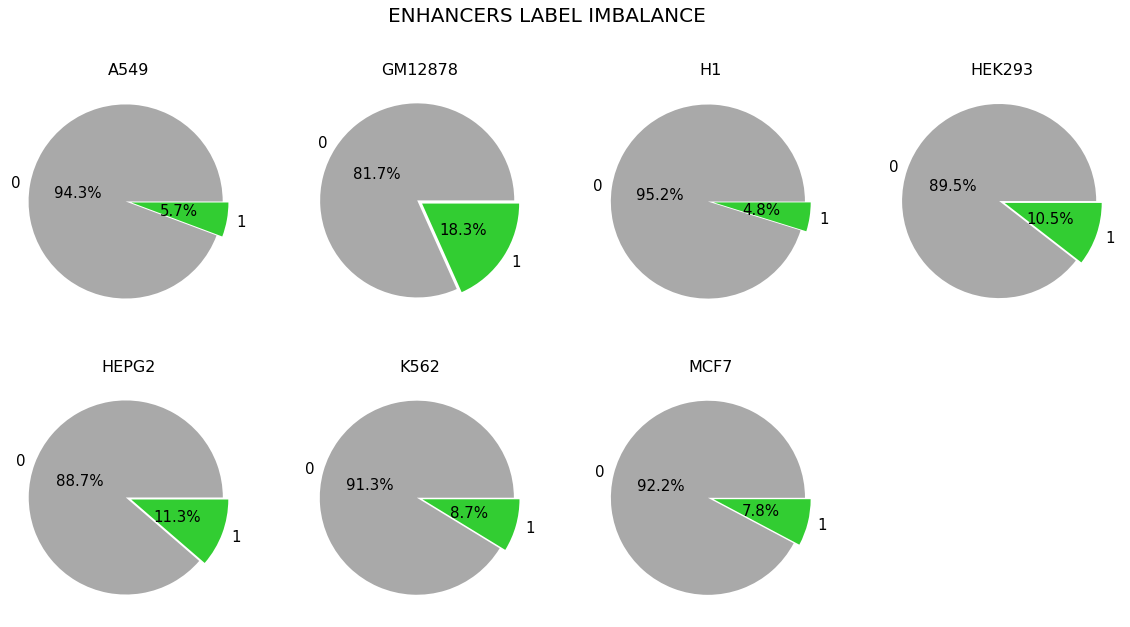

In [163]:
plot_label_ratio(enhancers_dict['bed'][['A549','GM12878','H1','HEK293','HEPG2','K562','MCF7']], 'ENHANCERS LABEL IMBALANCE')

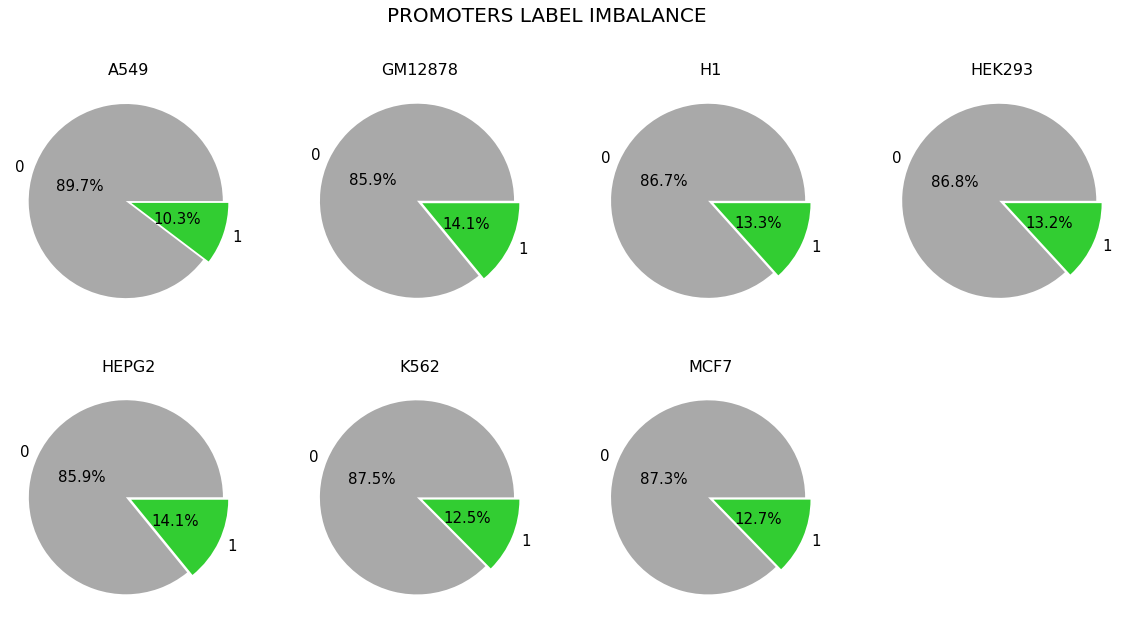

In [164]:
plot_label_ratio(promoters_dict['bed'][['A549','GM12878','H1','HEK293','HEPG2','K562','MCF7']], 'PROMOTERS LABEL IMBALANCE')

## PREPROCESSING FUNCTION

In [7]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import torch
import torch.nn.functional as F
import itertools
from scipy.stats import pointbiserialr
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from scipy.stats import spearmanr
from scipy.stats import entropy

class Data_Preparation():
    
    def __init__(self, data_dict, n_neighbors=5):
        
        self.label = data_dict['bed'].drop(['chrom','chromStart','chromEnd','strand'], axis=1)
        self.index = data_dict['bed'][['chrom','chromStart','chromEnd','strand']]
        self.data_dict = data_dict
        del self.data_dict['bed']
        
        self.data_dict['fa'] = self.data_dict['fa']['chromosome']
        
        # drop observations info
        for key in self.data_dict.keys():
            if key != 'fa':
                self.data_dict[key] = self.data_dict[key].drop(['chrom','chromStart','chromEnd','strand'], axis=1)
                
        
        self.n_neighbors = n_neighbors
        
        self.robust_scaler = RobustScaler()
      #  self.label_encoder = LabelEncoder()
       # self.onehot_encoder = OneHotEncoder(sparse=False) 
        self.knn_imputer = KNNImputer(n_neighbors=self.n_neighbors)
        
        self.X_train = []
        self.y_train = []
        self.X_test = []
        self.y_test = []
        
        self.sequence = []
        
        self.to_drop = dict()
    
                    
    def scale_data_genfeatures(self):
        for key in self.data_dict.keys():
            if key != 'fa':
                self.data_dict[key] = pd.DataFrame(self.robust_scaler.fit_transform(self.data_dict[key].values),
                                                   index=self.data_dict[key].index, 
                                                   columns=self.data_dict[key].columns)
                
    
    def knn_imputation_genfeatures(self):
        for key in self.data_dict.keys():
            if key != 'fa':
                self.data_dict[key] = pd.DataFrame(self.knn_imputer.fit_transform(self.data_dict[key].values),
                                                   index=self.data_dict[key].index, 
                                                   columns=self.data_dict[key].columns)
    
    
     # TRANSFORM WHEN LOADING INTO NETWORK
  #  def knn_imputation_sequence_fit(self):
   #     self.label_encoder.fit(np.array(['a','c','g','n','t']))
        
        # encode data since imputer works only with float
        #for i,seq in enumerate(self.data_dict['fa']):
         #   seq = [i for i in seq.lower()] 
          #  seq = self.label_encoder.transform(seq)
#            seq = [np.nan if i ==3 else i for i in seq]
 #           seq = self.knn_imputer.fit_transform(self.reshape(seq)).astype(int).round()
  #          self.data_dict['fa'][i] = seq
                
 #   def onehot_encode_data_sequence_fit(self):
  #      self.onehot_encoder.fit(np.array([0,1,2,4]).reshape(-1, 1)) 
        
#        for i,seq in enumerate(self.data_dict['fa']):
 #           self.data_dict['fa'][i] = self.onehot_encoder.transform(seq)
            
  #      self.data_dict['fa'] = torch.tensor(self.data_dict['fa'])
    
    def transform(self):
        
        self.scale_data_genfeatures()
        self.knn_imputation_genfeatures()
        
     #   self.knn_imputation_sequence()
      #  self.onehot_encode_data_sequence()
        
  

    def point_biserial_corr(self, X, y, verbose=False):
        """Point biserial correlation returns the correlation between a continuous and
        binary variable (target). It is a parametric test, so it assumes the data to be normally
        distributed."""
        
        uncorrelated = set()

        for col in X.columns:
            x = X[col]
            corr,_ = pointbiserialr(x,y)
            if abs(corr) < 0.05:
                uncorrelated.add(col)
                if verbose:
                    print('column: {}, Point-biserial Correlation: {}'.format(col, round(corr,4)))
        
        return uncorrelated
    
    
    def logistic_regression_corr(self, X, y, verbose=False):
        """The Logistic regression can be used to assess if a continuous variable has any 
         effect on the target. It doesn't assume anything about the distribution of the variables.
         The metric used is the area under the precision recall curve, which """
        
        uncorrelated = set()
        
        for col in X.columns:
            x = X[col].values.reshape(-1, 1)

            # perform 3-folds cv with logistic regression
            cv = KFold(n_splits=3, random_state=123, shuffle=True)
            model = LogisticRegression()

            baseline_binary_pos = len(y[y==1]) / len(y)

            # compute the AUPRC for the positive score
            AUPRC = make_scorer(average_precision_score, average='weighted')
            scores = cross_val_score(model, x, y, scoring=AUPRC, cv=cv, n_jobs=-1, error_score="raise")
        
            if scores.mean() <= baseline_binary_pos:
                uncorrelated.add(col)
                
                if verbose:
                    print('column: {}, AUPRC: {}, Baseline positive class: {}'.format(col, round(scores.mean(),4), round(baseline_binary_pos,4)))
        
        return uncorrelated

    
    def correlation_with_label(self, type_corr='all', verbose=False):
        
        if type_corr not in ['point_biserial_corr', 'logistic_regression', 'all']:
            raise ValueError(
            "Argument 'type_corr' has an incorrect value: use 'point_biserial_corr', 'logistic_regression', 'all'")
            
        
        if type_corr == 'logistic_regression':
            for key in self.data_dict.keys():
                if key != 'fa':
                    if verbose:
                        print(key)
                    self.to_drop[key] = self.logistic_regression_corr(self.data_dict[key], self.label[key], verbose=verbose)
                    # remove uncorrelated features
                    if self.to_drop[key]:
                        self.data_dict[key] = self.data_dict[key].drop(list(self.to_drop[key]), axis=1)
        
        
        elif type_corr == 'point_biserial_corr':    
            for key in self.data_dict.keys():
                if key != 'fa':
                    if verbose:
                        print(key)
                    self.to_drop[key] = self.point_biserial_corr(self.data_dict[key], self.label[key], verbose=verbose)
                    # remove uncorrelated features
                    if self.to_drop[key]:
                        self.data_dict[key] = self.data_dict[key].drop(list(self.to_drop[key]), axis=1)
        
        
        elif type_corr == 'all':
             for key in self.data_dict.keys():
                if key != 'fa':
                    if verbose:
                        print(key)
                    self.to_drop[key] = self.point_biserial_corr(self.data_dict[key], self.label[key], verbose=verbose)
                    self.to_drop[key].intersection(self.logistic_regression_corr(self.data_dict[key], self.label[key], verbose=verbose))
                    # remove uncorrelated features
                    if self.to_drop[key]:
                        self.data_dict[key] = self.data_dict[key].drop(list(self.to_drop[key]), axis=1)
        
    
    
    def spearman_corr(self, X, verbose=False):
        """Spearman correlation checks for linear correlation between continuous features.
        It is non-parametric, so normality of the variables is not necessary."""
        
        correlated = set()
        
        for col1, col2 in itertools.combinations(X.columns, 2):
            corr, _ = spearmanr(X[col1].values, X[col2].values)
            
            if corr >= 0.85:
                correlated.add(frozenset({col1,col2}))
                
                if verbose:
                    print('correlated columns: {} - {}, Spearman Correlation {}'.format(col1, col2, round(corr,4)))
        
        return correlated
    
    
    

    def remove_correlated_feature(self, X, y, correlated_pairs, verbose=False):

        correlated_to_remove = set()

        for pair in correlated_pairs:
            col1, col2 = pair
            x1 = X[col1].values.reshape(-1, 1)
            x2 = X[col2].values.reshape(-1, 1)

            # perform 3-folds cv with logistic regression
            cv = KFold(n_splits=3, random_state=123, shuffle=True)
            model = LogisticRegression()

            # compute the AUPRC for the positive score
            AUPRC = make_scorer(average_precision_score, average='weighted')
            scores1 = cross_val_score(model, x1, y, scoring=AUPRC, cv=cv, n_jobs=-1, error_score="raise")
            scores2 = cross_val_score(model, x1, y, scoring=AUPRC, cv=cv, n_jobs=-1, error_score="raise")

            if verbose:
                print('columns to compare: {} vs {}, AUPRC: {} vs {}'.format(col1, col2, scores1.mean(), scores2.mean()))

            if scores1.mean() >= scores2.mean():
                correlated_to_remove.add(col2)
            else:
                correlated_to_remove.add(col1)
    
    
    
    def correlation_btw_features(self, verbose=False):
        
        self.to_drop = dict()
        
        for key in self.data_dict.keys():
                if key != 'fa':
                    if verbose:
                        print(key)
                    correlated_pairs = self.spearman_corr(self.data_dict[key], verbose=verbose)
                    self.to_drop[key] =  self.remove_correlated_feature(self.data_dict[key], self.label[key], correlated_pairs, verbose=verbose)
                    # for each pair of correlated features, remove the one less correlated to the output
                    if self.to_drop[key]:
                        self.data_dict[key] = self.data_dict[key].drop(list(self.to_drop[key]), axis=1)
         
    
    def split_data(self, cell_line, test_size, validation_size):
        
        if self.sequence:
            assert (self.data_dict['fa'].shape[0] ==  len(self.label[cell_line]))
                    
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data_dict['fa'], 
                                                                                 self.label[cell_line],
                                                                                 test_size=test_size, 
                                                                                 random_state=456, shuffle=True) 

            if self.hyper_tuning:
                assert (self.X_train.shape[0] ==  len(self.y_train))
                    
                self.X_train, self.X_test,  self.y_train, self.y_test = train_test_split(self.X_train, 
                                                                                     self.y_train,
                                                                                     test_size=validation_size,
                                                                                     random_state=123, shuffle=True) 
                   
            
        else:
            assert (self.data_dict[cell_line].shape[0] ==  len(self.label[cell_line]))

            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data_dict[cell_line], 
                                                                                    self.label[cell_line],
                                                                                    test_size=test_size, 
                                                                                    random_state=123, shuffle=True) 
            
            if self.hyper_tuning: 
                assert (self.X_train.shape[0] ==  len(self.y_train))

                self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_train, 
                                                                                        self.y_train,
                                                                                        test_size=validation_size, 
                                                                                        random_state=456, shuffle=True) 
        
    
    def return_data(self, cell_line, hyper_tuning=False, sequence=True, test_size=0.25, validation_size=0.15):
        
      #  for key in self.data_dict.keys():
       #     if key != 'fa':
        #        if isinstance(self.data_dict[key], pd.DataFrame):
         #           self.data_dict[key] = torch.tensor(self.data_dict[key].values)
    
        self.sequence=sequence
        self.hyper_tuning=hyper_tuning
        
        if cell_line not in ['A549','GM12878', 'H1', 'HEK293', 'HEPG2', 'K562', 'MCF7']:
            raise ValueError(
            "Argument 'cell_line' has an incorrect value: use 'A549', 'GM12878', 'H1', 'HEK293', 'HEPG2', 'K562', 'MCF7'")
            
        
        self.split_data(cell_line=cell_line, test_size=test_size, validation_size=validation_size)
    

        return ( self.X_train.reset_index(drop=True), self.X_test.reset_index(drop=True), 
                self.y_train.reset_index(drop=True) , self.y_test.reset_index(drop=True),
                self.index )
                

In [44]:
from torch.utils.data import DataLoader, Dataset

class Dataset_Wrap(Dataset):
    def __init__(self, X, y, n_neighbors, sequence=False):
        super(Dataset_Wrap, self).__init__()
        
        self.X = X
        self.y = y
        self.n_neighbors = n_neighbors
        self.sequence = sequence
        
        self.pos_index = list(self.X[self.y==1].index)
        self.neg_index = list(self.X[self.y==0].index)
        
        # some observations don't have some of the nucleotides, so it will result in
        #matrices of different dimensions which cannot be concatenated
        self.label_encoder = LabelEncoder().fit(np.array(['a','c','g','n','t']))
        # get rid of value 3 which is 'n' (nan)
        self.onehot_encoder = OneHotEncoder(sparse=False).fit(np.array([0,1,2,4]).reshape(-1, 1)) 
        self.knn_imputer = KNNImputer(n_neighbors=self.n_neighbors)


    def __len__(self):
        return (self.X.shape[0])  

        
    def __getitem__(self, i):

        data = self.X.iloc[i]  
        
        if self.sequence:
            # all the letters in lowercase
            data = [i for i in data.lower()]
            
            # apply encoding
            data = self.label_encoder.transform(data)
            # value 3 corresponds to n (nan)
            data = [np.nan if i ==3 else i for i in data]
            
            # impute missing data with knn
            data =  self.knn_imputer.fit_transform( np.array(data).reshape(-1,1) ).astype(int).round()
            
            # one hot encode data
          #  data = self.onehot_encoder.transform(data)
        
        data = torch.tensor(data)
            
       # if self.sequence: 
            # (channels, size of the matrix)
        #    data = data.reshape(1, data.shape[0], data.shape[1])

        label = torch.tensor([self.y[i].astype(int)])

        return data.to(device), label.to(device)

In [33]:
import pickle
from varname import nameof

class Build_DataLoader_Pipeline():

    def __init__(self,
                 data_dict, 
                 path_name=None,
                 n_neighbors=5,
                 type_corr='all',
                 verbose=False):
    
        self.data_dict =  data_dict
        self.path_name = path_name
        self.n_neighbors = n_neighbors
        self.type_corr = type_corr
        self.verbose = verbose

        self.data_class = []
        self.transform = False
        self.correlation_with_label = False
        self.correlation_btw_features = False
        
        self.index = []
    
        
        # if there exists already the class of preprocessed data, load it
        # else instantiate it and do all the preprocessing
        if os.path.exists("data_preparation_class_{}".format(self.path_name)):
            with open("data_preparation_class_{}".format(self.path_name), "rb") as fin:
                self.data_class = pickle.load(fin)
        else:
            self.data_class = Data_Preparation(self.data_dict, n_neighbors=self.n_neighbors)
            self.data_class.transform()
            print('Data transformation Done!\n')
            self.data_class.correlation_with_label(type_corr=self.type_corr, verbose=self.verbose)
            print('Check correlation with labels Done!\n')
        #    self.data_class.correlation_btw_features(verbose=self.verbose)  
         #   print('Check correlation between features Done!\n')  
            
          #  with open("data_preparation_class_{}".format(self.path_name), "wb") as fout:
           #     pickle.dump(self.data_class, fout)
        
        print('Data Preprocessing Done!')
            
        
    def return_data(self, 
                    cell_line, 
                    hyper_tuning=False, 
                    sequence=False,
                    test_size=0.25, 
                    validation_size=0.15,
                    batch_size = 100):
            
        # retrieve the data 
        X_train, X_test, y_train, y_test, index = self.data_class.return_data(cell_line=cell_line, 
                                                                          hyper_tuning=hyper_tuning, 
                                                                          sequence=sequence,
                                                                          test_size=test_size,
                                                                          validation_size=validation_size)
        
        self.index = index
        
        train_wrap = Dataset_Wrap(X_train, y_train, sequence=sequence, self.n_neighbors=5)
        test_wrap = Dataset_Wrap(X_test, y_test, sequence=sequence, self.n_neighbors=5)
        
        loader_train = DataLoader(dataset = train_wrap, batch_size = batch_size, shuffle=True)             
        loader_test = DataLoader(dataset = test_wrap, batch_size = batch_size*2, shuffle=False)     

        return  loader_train, loader_test

In [34]:
enhancers_dict = data_load(enhancers)

In [180]:
pipe_data_load = Build_DataLoader_Pipeline(enhancers_dict, path_name='enhancers.pickle', verbose=False)

Data transformation Done!

Check correlation with labels Done!

Data Preprocessing Done!


In [732]:
loader_train, loader_test = pipe_data_load.return_data(cell_line='H1', 
                    hyper_tuning=True, 
                    sequence=False)

---

In [45]:
#data_class = Data_Preparation(enhancers_dict, n_neighbors=5)
#data_class.transform()

X_train, X_test, y_train, y_test, index = data_class.return_data(cell_line='H1', 
                                                                          hyper_tuning=True, 
                                                                          sequence=True)

In [46]:
train_wrap = Dataset_Wrap(X_train, y_train, sequence=True, n_neighbors=5)
test_wrap = Dataset_Wrap(X_test, y_test, sequence=True, n_neighbors=5)

In [47]:
from torch.utils.data import Sampler
import random

class BalancePos_BatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        
        self.pos_index = dataset.pos_index
        self.neg_index = dataset.neg_index
        
        self.batch_size = batch_size
        
        if len(dataset) % self.batch_size >0:
            self.n_batches = (len(dataset) // self.batch_size) +1
        else:
            self.n_batches = len(dataset) // self.batch_size
    
    def __iter__(self):
        random.shuffle(self.pos_index)
        random.shuffle(self.neg_index)
        
        # create chunks of positive and negative labels
        # chunks of positive labels
        pos_batches  = np.array_split(self.pos_index, self.n_batches+1)
        # chunks of negative labels
        neg_batches = np.array_split(self.neg_index, self.n_batches+1)
        neg_batches.reverse()
        
        # create batches of size 100 with the same number of positive obs. in this way we are guaranteed to have
        #evenly distributed positive observations across all the batches, so we can always apply SMOTE 
        balanced = [ np.concatenate((p_batch, n_batch)).tolist() for p_batch, n_batch in zip(pos_batches, neg_batches) ]
        random.shuffle(balanced)
        return iter(balanced)
    
    def __len__(self):
        return self.n_batches

In [48]:
batch_size=100
loader_train = DataLoader(dataset = train_wrap, batch_sampler = BalancePos_BatchSampler(train_wrap, batch_size= batch_size)) #, sampler=oversample)
loader_test = DataLoader(dataset = test_wrap, batch_sampler = BalancePos_BatchSampler(test_wrap, batch_size= batch_size*2)) 

In [762]:
for i, batch_indices in enumerate(loader_train.batch_sampler):
    print('Batch #{} indices: {}\n'.format(i, batch_indices))
    print('\nlen batch: {}\n'.format(len(batch_indices)))

Batch #0 indices: [10145, 3963, 6525, 6407, 18316, 18777, 36333, 16106, 28390, 25892, 9834, 2005, 28261, 3591, 27236, 24925, 13423, 7356, 7917, 35609, 28253, 12731, 7058, 27836, 11374, 19588, 18717, 35628, 34403, 19905, 13962, 9053, 37648, 264, 17155, 37671, 35695, 30809, 35784, 4850, 28266, 22267, 4147, 4590, 27734, 37959, 34560, 12519, 24363, 35377, 29960, 25621, 16257, 1915, 20601, 1272, 29903, 13867, 29985, 25882, 14803, 18082, 10543, 23097, 28526, 1898, 31533, 2589, 16371, 39032, 22948, 27474, 23454, 24447, 6969, 7709, 982, 11196, 20011, 23048, 23140, 2285, 37756, 18114, 2222, 7951, 628, 35867, 32541, 7731, 3570, 12986, 24426, 12710, 36549, 20588, 21855, 16727, 24910, 29211]


len batch: 100

Batch #1 indices: [27668, 24905, 8202, 5142, 20196, 26824, 795, 37212, 7669, 13085, 32863, 3195, 23133, 34620, 22644, 22910, 9147, 15457, 26540, 20035, 24327, 34214, 32133, 28398, 7760, 7283, 25515, 35006, 9174, 2819, 36488, 26192, 18310, 38818, 7405, 8656, 33157, 18721, 2663, 18954, 35851, 2

In [763]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=3)

for data, label in loader_train:
    data,label = oversample.fit_resample(data,label)
    data = torch.tensor(data)
    label = torch.tensor(label)
    break

In [174]:
from imblearn.over_sampling import SMOTEN
oversample = SMOTEN(k_neighbors=3)
onehot_encoder = OneHotEncoder(sparse=False).fit(np.array([0,1,2,4]).reshape(-1, 1)) 

for data, label in loader_train:
    
    # n_batches, n.elements per obs
    data = data.reshape(data.shape[0], -1)
    data,label = oversample.fit_resample(data,label)
    
    data_ = []
    for x in data:
        data_.append(onehot_encoder.transform(np.array(x).reshape(-1, 1)))
    
    # final size: n_batches, n_channels, size of matrix (256*4)
    data = torch.tensor(data_).reshape(-1,1,256,4)
    
    
    break